In [1]:
import torch
import torch.nn as nn
import numpy as np
from main import run

In [2]:
def load_glove_embeddings(file_path, word_to_index, embedding_dim):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings[word] = coefs

    num_words = len(word_to_index)+1  # add 1 for the padding token
    embedding_matrix = np.zeros((num_words, embedding_dim))

    for word, index in word_to_index.items():
        if (embedding := embeddings.get(word)) is not None:
            embedding_matrix[index] = embedding
        else:
            embedding_matrix[index] = embeddings.get("<unk>", np.zeros(embedding_dim))

    return embedding_matrix

In [3]:
class SimpleRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, output_size, embedding_dim):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        output = self.fc(output)
        return output

Epoch: 15/15
Validation Loss: 0.0729
Validation Macro F1: 0.7290
Training Macro F1: 0.7215


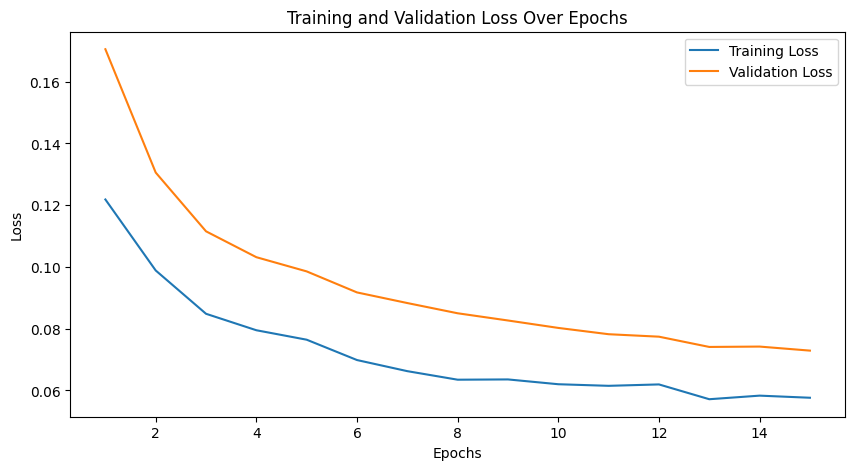

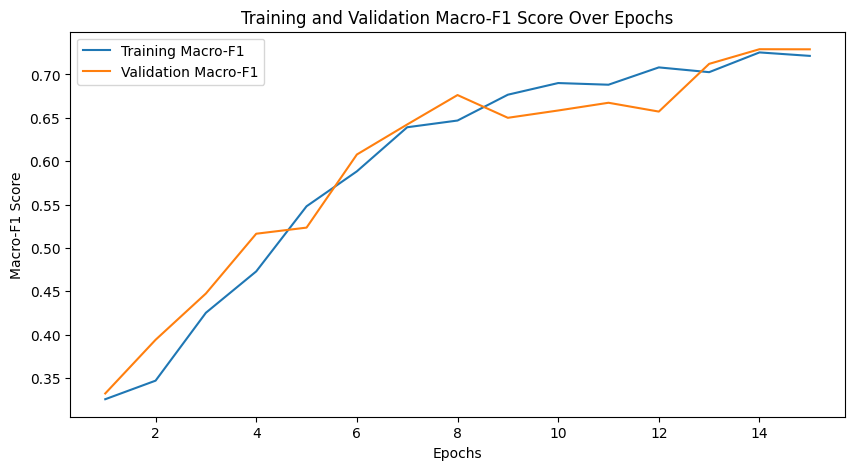

Final Test Accuracy: 0.9666
Final Test Macro F1: 0.6821


In [4]:
run(load_glove_embeddings, 100, "../word_embeddings/glove.6B.100d.txt", SimpleRNN, "rnn_glove")